In [14]:
#Importing the required libraries

import matplotlib.pyplot as plt
import tensorflow.keras as K
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras.datasets import cifar10
from keras.layers import Dense,Dropout, Flatten, Conv2D, MaxPooling2D, Layer, Lambda, BatchNormalization, GlobalAveragePooling2D
import numpy as np

In [2]:
#I am using densenet to prepocess the data

def preprocess_data(X, Y):
    X_p = K.applications.densenet.preprocess_input(X)

    # encode to one-hot
    Y_p = K.utils.to_categorical(Y, 10)
    return X_p, Y_p

In [3]:
#This block of will be used to save the model

CALLBACKS = []
MODEL_PATH = '/content/model'
optimizer = K.optimizers.Adam()

#Instead of uploading the dataset maually i downloaded it directly from the tensorflow website

(x_train, y_train), (x_test, y_test) = K.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 3s 0us/step


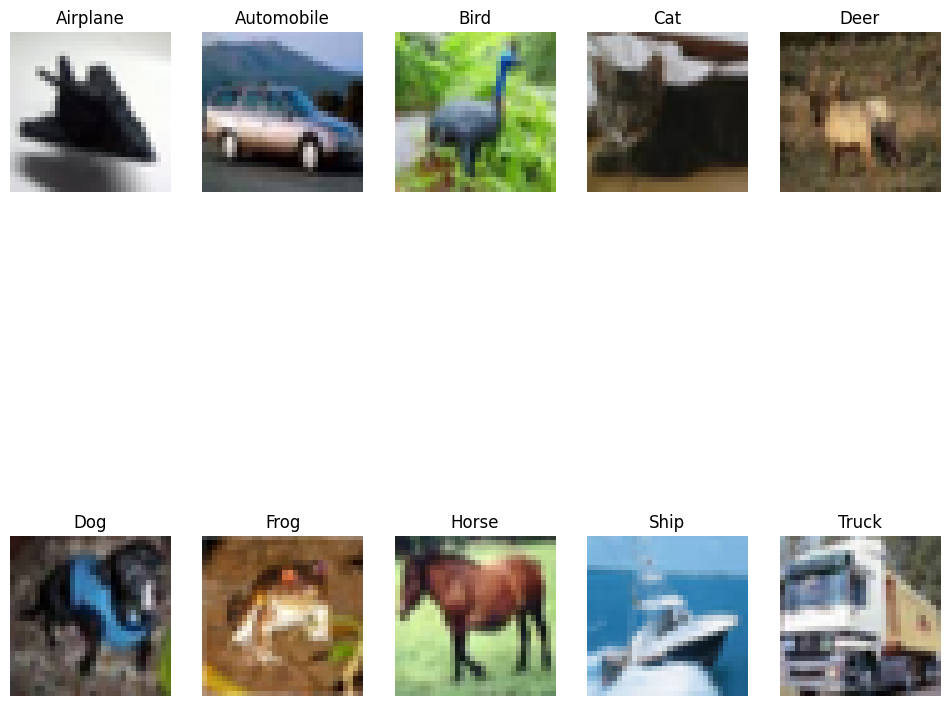

Number of training examples: 50000
Number of test examples: 10000
Image shape: (32, 32, 3)
Number of classes: 10


In [11]:
#Printing some samples
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Distribution of classes
unique, counts = np.unique(y_train, return_counts=True)
class_distribution = dict(zip(class_names, counts))

# Show sample images from each class
plt.figure(figsize=(12, 12))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    class_images = x_train[np.where(y_train == i)[0]]
    plt.imshow(class_images[0])
    plt.title(class_names[i])
    plt.axis('off')
plt.show()

# Image statistics
print("Number of training examples:", len(x_train))
print("Number of test examples:", len(x_test))
print("Image shape:", x_train[0].shape)
print("Number of classes:", len(class_names))

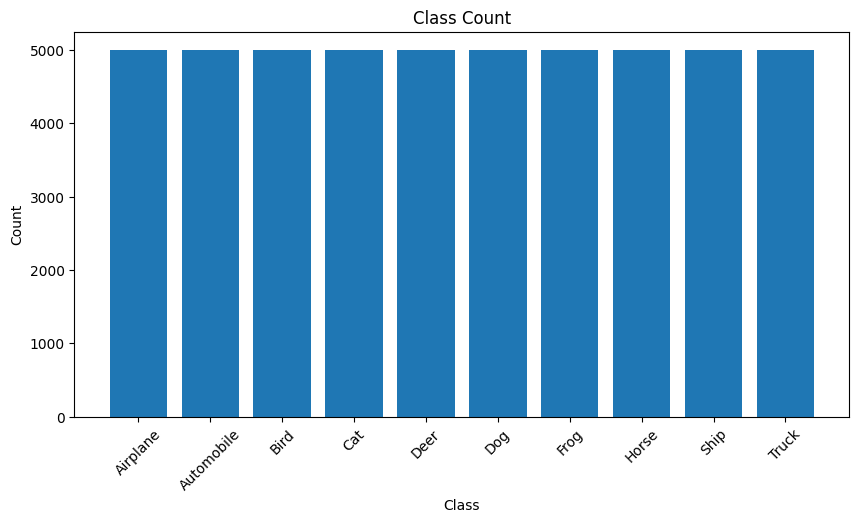

Airplane: 5000 samples
Automobile: 5000 samples
Bird: 5000 samples
Cat: 5000 samples
Deer: 5000 samples
Dog: 5000 samples
Frog: 5000 samples
Horse: 5000 samples
Ship: 5000 samples
Truck: 5000 samples


In [13]:
#Printing the count of each class

class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Count the number of samples in each class
class_counts = [np.sum(y_train == i) for i in range(len(class_names))]

# Display the count of each class
plt.figure(figsize=(10, 5))
plt.bar(class_names, class_counts)
plt.title('Class Count')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Print the count of each class
for i, class_name in enumerate(class_names):
    print(f"{class_name}: {class_counts[i]} samples")

In [ ]:
#This is data preprocessing
x_train, y_train = preprocess_data(x_train, y_train)
x_test, y_test = preprocess_data(x_test, y_test)

# input tensor
inputs = K.Input(shape=(32, 32, 3))

# upscale layer
upscale = K.layers.Lambda(lambda x: tf.image.resize_with_pad(x,
                                                                  160,
                                                                  160,
                                                                  method=tf.image.ResizeMethod.BILINEAR))(inputs)

In [ ]:
#Defining the layers for training
#Using DenseNet121 for transfer learning

base_model = K.applications.DenseNet121(include_top=False,
                                        weights='imagenet',
                                        input_tensor=upscale,
                                        input_shape=(160,160,3))



# add top layers
out = base_model.output
out = Flatten()(out)
out = BatchNormalization()(out)
out = Dense(124, activation='relu')(out)
out = Dropout(0.7)(out)
out = BatchNormalization()(out)
out = Dense(64, activation='relu')(out)
out = Dropout(0.4)(out)
out = Dense(10, activation='softmax')(out)

29084464/29084464 [==============================] - 0s 0us/step


In [ ]:
CALLBACKS.append(K.callbacks.ModelCheckpoint(filepath=MODEL_PATH,
                                              monitor='val_accuracy',
                                              save_best_only=True))

CALLBACKS.append(K.callbacks.EarlyStopping(monitor='val_accuracy',
                                            verbose=1,
                                            patience=5))
CALLBACKS.append(K.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                         patience=2, verbose=1))

# CALLBACKS.append(K.callbacks.TensorBoard(log_dir='logs'))
# model compile
model = K.models.Model(inputs=inputs, outputs=out)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(x=x_train,
          y=y_train,
          batch_size=128,
          epochs=20,
          callbacks=CALLBACKS,
          validation_data=(x_test, y_test))

Epoch 1/20
391/391 [==============================] - 425s 901ms/step - loss: 0.9403 - accuracy: 0.7121 - val_loss: 0.8037 - val_accuracy: 0.7708 - lr: 0.0010
Epoch 2/20
391/391 [==============================] - 346s 887ms/step - loss: 0.5005 - accuracy: 0.8562 - val_loss: 0.6621 - val_accuracy: 0.8131 - lr: 0.0010
Epoch 3/20
391/391 [==============================] - 339s 868ms/step - loss: 0.3981 - accuracy: 0.8868 - val_loss: 0.5022 - val_accuracy: 0.8476 - lr: 0.0010
Epoch 4/20
391/391 [==============================] - 292s 748ms/step - loss: 0.3237 - accuracy: 0.9065 - val_loss: 0.6487 - val_accuracy: 0.8207 - lr: 0.0010
Epoch 5/20
391/391 [==============================] - 342s 875ms/step - loss: 0.2773 - accuracy: 0.9225 - val_loss: 0.3839 - val_accuracy: 0.8910 - lr: 0.0010
Epoch 6/20
391/391 [==============================] - 292s 747ms/step - loss: 0.2450 - accuracy: 0.9307 - val_loss: 0.4172 - val_accuracy: 0.8805 - lr: 0.0010
Epoch 7/20
391/391 [==========================

In [ ]:
model.evaluate(x_test, y_test, batch_size=128, verbose=1)

79/79 [==============================] - 14s 170ms/step - loss: 0.1673 - accuracy: 0.9568


[0.16727207601070404, 0.9567999839782715]

We got the accuracy of 95% which is fantastic

In [ ]:
#Saving the model
model.save('cifar10dense101.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


We will use this model to predict the class label of new images in a new .ipynb file to test its functionality